### Importing, normailizing and separating data

In [77]:
import numpy as np 
import tensorflow as tf
from spektral.layers import GCNConv, GlobalSumPool
from sklearn.preprocessing import StandardScaler

truss_dat = np.load("Truss_dat.npy")
truss_areas = np.load("Truss_areas.npy")
truss_edges = np.load("Truss_edges.npy")
truss_disps = np.load("Stress_Disp_dat.npy")

e = 1e-15

scaler = StandardScaler()
scaled_disps = scaler.fit_transform(truss_disps)


max_force = np.max(np.abs(truss_dat[:,:,2:3]))
max_pos = np.max(np.abs(truss_dat[:,:,0:1]))
max_area = np.max(truss_areas)

truss_dat[:,:,0] #/= max_pos
truss_dat[:,:,1] #/= max_pos
truss_dat[:,:,2] /= max_force
truss_dat[:,:,3] /= max_force
truss_areas /= max_area

### Building network architecture

In [78]:
from keras import Input,Model
from keras.layers import Dense,Add
import keras.backend as K

n_nodes = 6     
n_features = 7
latent_dim = 64 
n_edges = 10      

#   Defining Input
X_in = Input(shape=(n_nodes,n_features), name='X_in')  # shape: (n_nodes, n_features)
A_in = Input(shape=(n_nodes,n_nodes), name='A_in')  # shape: (n_nodes, n_nodes), sparse

#   Defining encoder
x1 = GCNConv(64, activation='relu')([X_in, A_in])
x2 = GCNConv(64, activation='relu')([x1, A_in])
add = Add()([x1,x2])
x = GCNConv(32, activation='relu')([add, A_in])
z = GlobalSumPool()(x)
z = Dense(latent_dim, activation='relu', name='latent_vector')(z)

#   Defining displacement FC
disp_FC = Dense(128,activation='relu')(z)
disp_FC = Dense(300)(disp_FC)
disp_FC = Dense(2*n_nodes, name="Disps")(disp_FC)

#   Building and compiling model
model = Model(inputs=[X_in, A_in], outputs=disp_FC,name="GNN_Autoencoder")

mean = tf.constant(scaler.mean_, dtype=tf.float32)
scale = tf.constant(scaler.scale_, dtype=tf.float32)

def inverse_transform(tensor):
    return tensor * scale + mean

def true_error(y_true, y_pred):
    true = inverse_transform(y_true)
    pred = inverse_transform(y_pred)
    error = tf.abs(true - pred)
    return tf.reduce_mean(error)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mae",
    metrics = true_error
)

### Constructing dense adjacency matrices

In [79]:
def build_dense_array(edges,areas):
    A = np.zeros([n_nodes,n_nodes])

    for edge, area in zip(edges, areas):
        i,j = tuple(edge)
        A[i,j] = area
        A[j,i] = area
    
    return A

A_all = [build_dense_array(edges,areas) for edges,areas in zip(truss_edges,truss_areas)]


A_all = np.array(A_all)
print(A_all.shape)

(20000, 6, 6)


### Setting training parameters and training network

In [80]:
from sklearn.model_selection import train_test_split

epochs = 50
batch_size = 32
val_split = 0.1

feat_train, feat_test, A_train, A_test, disp_train, disp_test = train_test_split(truss_dat,A_all,scaled_disps,train_size=0.7)

X_train = [feat_train, A_train]
y_train = disp_train

X_test = [feat_test, A_test]
y_test = disp_test

history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=val_split)

Epoch 1/50
394/394 [==============================] - 3s 3ms/step - loss: 0.3870 - true_error: 0.0227 - val_loss: 0.3385 - val_true_error: 0.0082
Epoch 2/50
394/394 [==============================] - 1s 2ms/step - loss: 0.3281 - true_error: 0.0066 - val_loss: 0.3099 - val_true_error: 0.0042
Epoch 3/50
394/394 [==============================] - 1s 2ms/step - loss: 0.3123 - true_error: 0.0056 - val_loss: 0.3013 - val_true_error: 0.0042
Epoch 4/50
394/394 [==============================] - 1s 2ms/step - loss: 0.2988 - true_error: 0.0053 - val_loss: 0.2960 - val_true_error: 0.0072
Epoch 5/50
394/394 [==============================] - 1s 3ms/step - loss: 0.2927 - true_error: 0.0054 - val_loss: 0.2921 - val_true_error: 0.0040
Epoch 6/50
394/394 [==============================] - 1s 3ms/step - loss: 0.2861 - true_error: 0.0047 - val_loss: 0.2851 - val_true_error: 0.0042
Epoch 7/50
394/394 [==============================] - 1s 3ms/step - loss: 0.2838 - true_error: 0.0045 - val_loss: 0.2791 - v

### Determining model accuracy

In [81]:
from keras.metrics import MeanAbsolutePercentageError, MeanAbsoluteError

mape = MeanAbsolutePercentageError()
mae = MeanAbsoluteError()

y_true = scaler.inverse_transform(disp_test)
preds = scaler.inverse_transform(model.predict(X_test))

preds[:,0:4] = 0

mape.update_state(y_true,preds)
mae.update_state(y_true,preds)

print("Average percent error:", mape.result().numpy(), "%")
print("Mean absolute error:", mae.result().numpy())

188/188 [==============================] - 0s 1ms/step
Average percent error: 208.17822 %
Mean absolute error: 0.00011153068


This model is preforming incredibly well for predicting displacements from truss inputs. I made the decision to switch to a graph based network after some searching and the realization that a CNN was not well-suited for my problem. This decision seems to have paid off, as this model is proving to be able to much better handle this type of data. 

Text(0, 0.5, 'Mean Absolute Error')

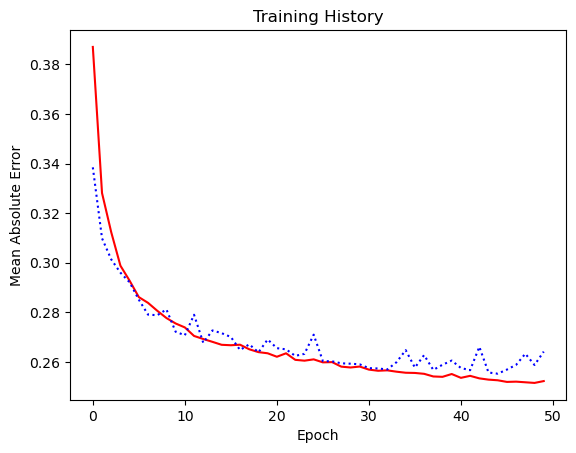

In [82]:
import matplotlib.pyplot as plt
train_err = history.history['loss']
val_err = history.history['val_loss']
epochs = history.epoch

plt.plot(epochs,train_err,"r-")
plt.plot(epochs,val_err,'b:')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")